# Hydrodynamics HW2 - Computational Aspects
## Andrew Bennett

First we import the necessary libraries for our code to run:

In [1]:
import numpy as np
from numba import jit
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

## Problem 3 - Part A

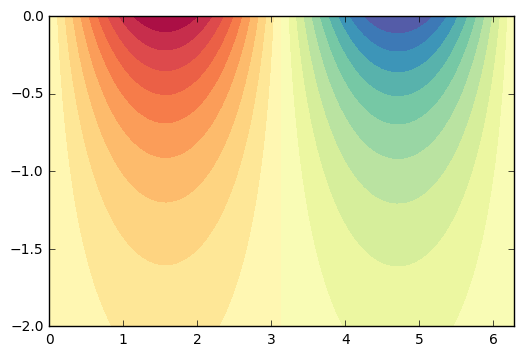

In [4]:
def number_3_part_a(a=1, C=1, k=1, w=1, nx=100):
    t = 0
    x1 = np.linspace(0, 2*np.pi, nx)
    x3 = np.linspace(-2, 0, nx)
    x1, x3 = np.meshgrid(x1, x3)
    psi = -a * C * np.exp(k*x3) * np.sin(k*x1 - w*t)
    plt.contourf(x1, x3, psi, 20, cmap=plt.get_cmap('Spectral')) 
    plt.show()

number_3_part_a()

## Problem 3 - Part D

0.0180341655955 -0.000692215735556


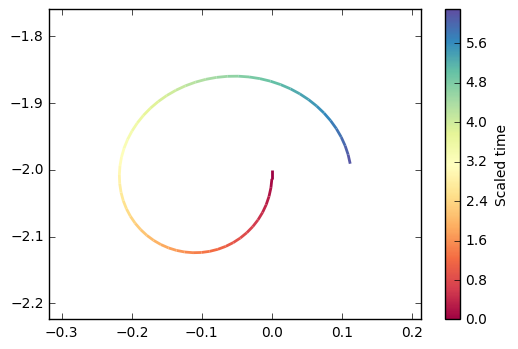

In [5]:
def number_3_part_d(x0=0.0, z0=-2.0, dt=0.1):
    a=1
    C=1
    k=1
    w=1
    t_list = np.linspace(0, 2*np.pi, 2*np.pi/dt)
    x = np.zeros(len(t_list)+1)
    z = np.zeros(len(t_list)+1)
    x[0], z[0] = x0, z0
     
    for i, t in enumerate(t_list):
        vx = a*k*C * np.exp(k*z[i]) * np.sin(k*x[i] - w*t)
        vz = -a*k*C * np.exp(k*z[i]) * np.cos(k*x[i] - w*t)
        x[i+1], z[i+1] = x[i]+vx*dt, z[i]+vz*dt
    xmin, xmax = min(x)-0.1, max(x)+0.1
    zmin, zmax = min(z)-0.1, max(z)+0.1
    fig = plt.figure() 
    vx_m = (x[-1]-x[0])/t_list[-1]
    vz_m = (z[-1]-z[0])/t_list[-1]
    print(vx_m, vz_m)
    
    points = np.array([x[:-1],z[:-1]]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=plt.get_cmap('Spectral'), 
                        norm=plt.Normalize(0,2*np.pi))
    lc.set_array(t_list)
    lc.set_linewidth(2)
    plt.gca().add_collection(lc)
    plt.xlim(xmin, xmax)
    plt.ylim(zmin, zmax)
    cb = fig.colorbar(lc)
    cb.set_label('Scaled time')
    plt.savefig("out.png")
    plt.show()

number_3_part_d()

## Problem 6 - bonus

### General Solver

In [2]:
@jit(nopython=True)
def number_6_general(x_coords, y_coords, gamma, dt=0.1, t_end=20):
    n_vortices = len(x_coords)
    x = np.zeros((int(t_end/dt)+1, len(x_coords)))
    y = np.zeros_like(x)
    x[0] = x_coords
    y[0] = y_coords
    t_list = np.arange(0, t_end, dt)

    for t in range(len(t_list)):
        for i in range(n_vortices):
            vx = 0
            vy = 0
            for j in range(n_vortices):
                if i != j:
                    dx = x[t, i] - x[t, j]
                    dy = y[t, i] - y[t, j]
                    r2 = dy**2 + dx**2
                    vx += -(gamma[j]*dy) / (2 * np.pi * r2)
                    vy += (gamma[j]*dx) / (2 * np.pi * r2)
            x[t+1, i] = x[t, i] + vx*dt
            y[t+1, i] = y[t, i] + vy*dt

    return x.T, y.T, t_list


### Problem 6 - computation

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


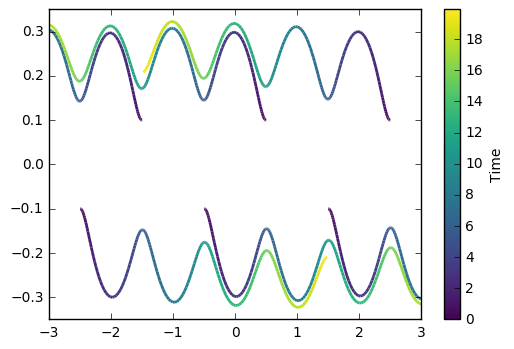

In [3]:
def number_6_bonus(a, b, gamma, n=100):
    x_coords = np.linspace(-(n/2)*a, (n/2)*a, n)
    y_coords = np.ones(n) * b
    y_coords[1::2] *= -1
    gammas = np.ones(n) * gamma
    x, y, t = number_6_general(x_coords, y_coords, gammas)
    fig = plt.figure()
    n_p = 3
    for i in np.arange(-n_p-1, n_p+1):
        points = np.array([x[(n/2)+i, :-1],y[(n/2)+i, :-1]]).T.reshape(-1,1,2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=plt.get_cmap('viridis'), 
                            norm=plt.Normalize(0,t[-1]))
        lc.set_array(t)
        lc.set_linewidth(2)
        plt.gca().add_collection(lc)
    plt.xlim(-n_p*a, n_p*a)
    plt.ylim(-3.5*b, 3.5*b)
    cb = fig.colorbar(lc)
    cb.set_label('Time')
    plt.show()
    
number_6_bonus(1, 0.1, 1, 3000)

## For fun

I figured I'd write up a general version of the multiple vortex interaction so I could play with it

### Triangular node - steady state?

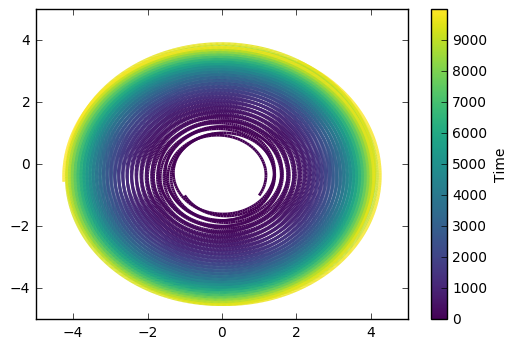

In [49]:
x = [-1,  0, +1 ]
y = [-1,  1, -1 ]
g = [ 1., 1., 1.]
x,y,t = number_6_general(x,y,g, dt=0.6, t_end=10000)

# Plotting
fig = plt.figure()
for i in range(len(x)):
    points = np.array([x[i, :-1],y[i, :-1]]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=plt.get_cmap('viridis'), 
                        norm=plt.Normalize(0,t[-1]))
    lc.set_array(t)
    lc.set_linewidth(2)
    plt.gca().add_collection(lc)
    
plt.xlim(-5, 5)
plt.ylim(-5, 5)
cb = fig.colorbar(lc)
cb.set_label('Time')
plt.show()

### Random circulation grid

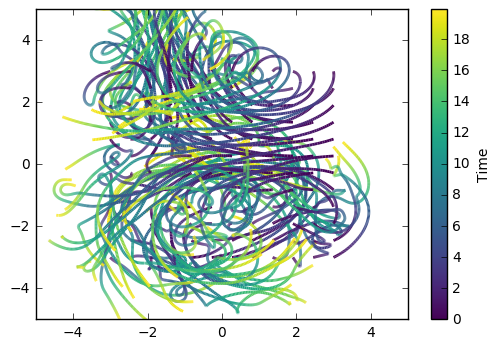

In [67]:
N = 12
x = np.linspace(-3,3,N)
y = np.linspace(-3,3,N)
g = 0.5 - np.random.random(len(x)*len(y))
x,y = np.meshgrid(x,y)
x, y = x.flatten(), y.flatten()

x,y,t = number_6_general(x,y,g, dt=0.1, t_end=20)

# Plotting
fig = plt.figure()
for i in range(len(x)):
    points = np.array([x[i, :-1],y[i, :-1]]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=plt.get_cmap('viridis'), 
                        norm=plt.Normalize(0,t[-1]))
    lc.set_array(t)
    lc.set_linewidth(2)
    plt.gca().add_collection(lc)
    
plt.xlim(-5, 5)
plt.ylim(-5, 5)
cb = fig.colorbar(lc)
cb.set_label('Time')
plt.show()

### Sinusoidal Circulation on a line

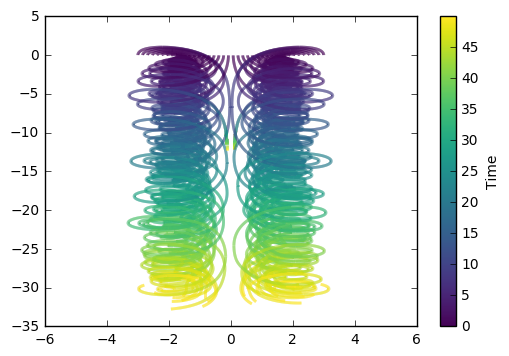

In [34]:
N = 40
x = np.linspace(-3,3,N)
y = np.zeros_like(x)
#x,y = np.meshgrid(x,y)
#x, y = x.flatten(), y.flatten()
g = np.sin(x)

x,y,t = number_6_general(x,y,g, dt=0.01, t_end=50)

# Plotting
fig = plt.figure()
for i in range(len(x)):
    points = np.array([x[i, :-1],y[i, :-1]]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=plt.get_cmap('viridis'), 
                        norm=plt.Normalize(0,t[-1]))
    lc.set_array(t)
    lc.set_linewidth(2)
    plt.gca().add_collection(lc)
    
plt.xlim(-6, 6)
plt.ylim(-35, 5)
cb = fig.colorbar(lc)
cb.set_label('Time')
plt.show()

### Chaotic Triangle

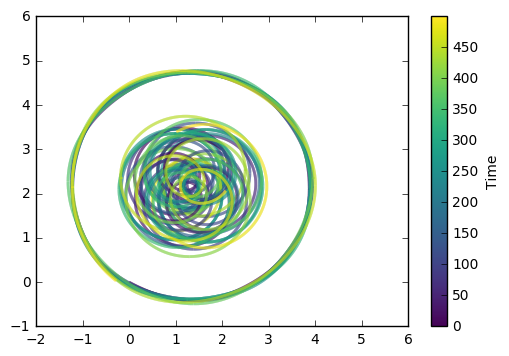

In [60]:
N = 3
x = [0,1,2]
y = [0,2,3]
g = [1,2,3]

x,y,t = number_6_general(x,y,g, dt=0.01, t_end=500)

# Plotting
fig = plt.figure()
for i in range(len(x)):
    points = np.array([x[i, :-1],y[i, :-1]]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=plt.get_cmap('viridis'), 
                        norm=plt.Normalize(0,t[-1]))
    lc.set_array(t)
    lc.set_linewidth(2)
    plt.gca().add_collection(lc)
    
plt.xlim(-2, 6)
plt.ylim(-1, 6)
cb = fig.colorbar(lc)
cb.set_label('Time')
plt.show()

### 4 Level twisty sheet

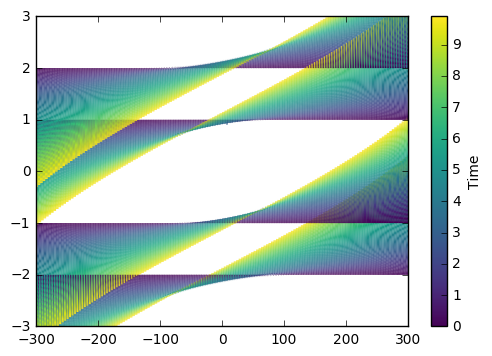

In [71]:
n = 1000
x_coords = np.linspace(-(n/2), (n/2), n)
y_coords = np.zeros_like(x_coords)
y_coords[1::4] += -2
y_coords[2::4] += -1
y_coords[3::4] += 1
y_coords[4::4] += 2
gammas = np.ones_like(x_coords)
x, y, t = number_6_general(x_coords, y_coords, gammas, t_end=10)

# Plotting
fig = plt.figure()
for i in range(len(x)):
    points = np.array([x[i, :-1],y[i, :-1]]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=plt.get_cmap('viridis'), 
                        norm=plt.Normalize(0,t[-1]))
    lc.set_array(t)
    lc.set_linewidth(2)
    plt.gca().add_collection(lc)
    
plt.xlim(-300, 300)
plt.ylim(-3, 3)
cb = fig.colorbar(lc)
cb.set_label('Time')
plt.show()

### Random locations & circulations - dipole escapse!

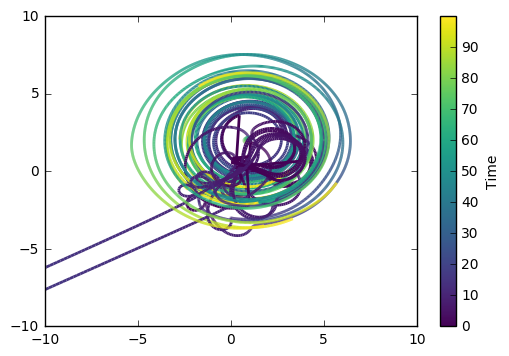

In [4]:
N = 4
x = np.random.random(N)
y = np.random.random(N)
g = np.random.random(N) - 0.5
x,y = np.meshgrid(x,y)
x, y = x.flatten(), y.flatten()

x,y,t = number_6_general(x,y,g, dt=0.1, t_end=100)

# Plotting
fig = plt.figure()
for i in range(len(x)):
    points = np.array([x[i, :-1],y[i, :-1]]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=plt.get_cmap('viridis'), 
                        norm=plt.Normalize(0,t[-1]))
    lc.set_array(t)
    lc.set_linewidth(2)
    plt.gca().add_collection(lc)
    
plt.xlim(-10, 10)
plt.ylim(-10, 10)
cb = fig.colorbar(lc)
cb.set_label('Time')
plt.show()